In [4]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from tensorflow import keras
from keras.models import Sequential
from keras import Input
from keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.callbacks import EarlyStopping

from lightgbm import LGBMRegressor
import random
import xgboost as xgb

In [2]:
curr_dir = os.getcwd()
curr_dir

'C:\\weather\\uv_new'

In [3]:
forders_tr = os.listdir(curr_dir+"\\data\\"+"\\outlier_train_val")
forders_tr

['2001_uv_nooutlier.csv',
 '2002_uv_nooutlier.csv',
 '2003_uv_nooutlier.csv',
 '2004_uv_nooutlier.csv',
 '2005_uv_nooutlier.csv',
 '2006_uv_nooutlier.csv',
 '2007_uv_nooutlier.csv',
 '2008_uv_nooutlier.csv',
 '2009_uv_nooutlier.csv',
 '2010_uv_nooutlier.csv',
 '2011_uv_nooutlier.csv',
 '2012_uv_nooutlier.csv',
 '2101_uv_nooutlier.csv',
 '2102_uv_nooutlier.csv',
 '2103_uv_nooutlier.csv',
 '2104_uv_nooutlier.csv',
 '2105_uv_nooutlier.csv',
 '2106_uv_nooutlier.csv',
 '2107_uv_nooutlier.csv',
 '2108_uv_nooutlier.csv',
 '2109_uv_nooutlier.csv',
 '2110_uv_nooutlier.csv',
 '2111_uv_nooutlier.csv',
 '2112_uv_nooutlier.csv']

In [4]:
summer_tr = forders_tr[4:10] + forders_tr[12+4:12+10-3]
summer_tr

summer_val = forders_tr[12+10-3:12+10]
summer_val

['2108_uv_nooutlier.csv', '2109_uv_nooutlier.csv', '2110_uv_nooutlier.csv']

In [5]:
train = pd.DataFrame()

for files in summer_tr:
    df= pd.read_csv(os.path.join(curr_dir+"\\data\\"+"\\outlier_train_val\\")+files)
    train = pd.concat([train, df])
    
train.drop('idx', axis=1, inplace=True)
train

,yyyymmdd,hhnn,stn,lon,lat,uv,band1,band2,band3,band4,...,band12,band13,band14,band15,band16,solarza,sateza,esr,height,landtype
0,20200501,0,13,126.16000,33.30000,0.0,0.00000,-0.00057,-0.00030,0.00165,...,252.91737,277.63245,277.03649,275.67037,262.71147,130.35092,38.96359,-6.11462,71.00,0
1,20200501,0,105,128.89098,37.75147,0.0,-0.00057,-0.00057,-0.00060,-0.00090,...,256.69212,286.82011,287.23821,285.51819,269.40510,126.43187,43.95463,-5.60867,26.04,3
2,20200501,0,108,126.96500,37.57100,0.0,0.00000,0.00000,0.00000,0.00090,...,253.85590,281.28558,281.42512,280.03692,266.81080,126.31564,43.77999,-5.59822,85.50,3
3,20200501,0,112,126.62490,37.47772,0.0,0.00000,0.00000,0.00089,0.00030,...,254.78101,283.03827,283.39275,282.06360,268.05385,126.36437,43.67046,-5.60546,68.99,3
4,20200501,0,115,130.89864,37.48129,0.0,0.00000,0.00000,0.00030,0.00075,...,251.68704,277.82840,278.25056,275.71853,262.56565,126.91833,43.74521,-5.66707,222.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65607,20210731,2350,146,127.11900,35.84080,0.1,0.00000,-0.00057,0.00030,-0.00060,...,264.53165,291.90287,290.09587,285.48855,270.82702,124.36364,41.81018,-4.72602,62.90,3
65608,20210731,2350,152,129.33472,35.58250,0.0,0.00000,0.00000,0.00000,-0.00030,...,262.88449,288.27382,286.67481,282.45891,269.23268,125.09137,41.52495,-4.87156,82.00,2
65609,20210731,2350,156,126.89158,35.17294,0.0,-0.00057,0.00000,0.00000,0.00015,...,262.57588,287.50208,284.96722,280.05240,267.56515,124.95628,41.04849,-4.79509,72.38,3
65610,20210731,2350,159,129.03203,35.10468,0.0,0.00000,0.00000,-0.00119,0.00000,...,262.22936,287.43410,286.66069,283.63739,270.60537,125.49764,40.96396,-4.91507,69.56,3


In [6]:
ratio=[]
num = []
for i in range(len(train.columns)):
    ratio.append(len(train[train[train.columns[i]] == -999.0])/len(train))
    num.append(len(train[train[train.columns[i]] == -999.0]))
ratio

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [7]:
val = pd.DataFrame()

for files in summer_val:
    df= pd.read_csv(os.path.join(curr_dir+"\\data\\"+"\\outlier_train_val\\")+files)
    val = pd.concat([val, df])
    
val.drop('idx', axis=1, inplace=True)
val

,yyyymmdd,hhnn,stn,lon,lat,uv,band1,band2,band3,band4,...,band12,band13,band14,band15,band16,solarza,sateza,esr,height,landtype
0,20210801,0,13,126.16000,33.30000,0.0,0.00000,-0.00057,0.00089,-0.00015,...,264.44311,290.55389,288.92546,284.67080,270.70772,127.16116,38.96359,-5.60122,71.00,0
1,20210801,0,105,128.89098,37.75147,0.0,-0.00057,-0.00057,0.00000,-0.00015,...,259.14507,283.10942,282.76528,280.43877,268.61000,123.36327,43.95463,-5.09260,26.04,3
2,20210801,0,108,126.96500,37.57100,0.0,0.00000,0.00057,-0.00119,0.00120,...,252.93837,273.65182,270.18990,267.15459,258.99048,123.18739,43.77999,-5.07447,85.50,3
3,20210801,0,112,126.62490,37.47772,0.0,0.00000,0.00000,-0.00030,-0.00060,...,250.27920,268.14394,268.04466,266.56403,259.34748,123.22507,43.67046,-5.08058,68.99,3
4,20210801,0,115,130.89864,37.48129,0.0,0.00000,0.00000,0.00000,-0.00015,...,263.38986,289.67998,288.05013,284.04277,269.26719,123.91259,43.74521,-5.16058,222.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62893,20211031,2350,146,127.11900,35.84080,0.1,0.00000,-0.00057,0.00030,-0.00015,...,243.98668,261.95199,261.21896,259.29863,250.50021,157.14313,41.81018,-8.56636,62.90,3
62894,20211031,2350,152,129.33472,35.58250,0.0,0.00000,0.00000,-0.00089,0.00120,...,255.89419,281.48837,281.57322,280.00595,265.73255,157.99342,41.52495,-8.67521,82.00,2
62895,20211031,2350,156,126.89158,35.17294,0.0,0.00057,0.00000,0.00000,0.00015,...,246.57815,265.43902,264.76641,262.60697,252.65714,157.69250,41.04849,-8.59148,72.38,3
62896,20211031,2350,159,129.03203,35.10468,0.0,0.00057,0.00000,-0.00179,-0.00060,...,257.75436,284.11394,283.85736,280.96228,265.34129,158.37811,40.96396,-8.68840,69.56,3


In [8]:
ratio=[]
num = []
for i in range(len(val.columns)):
    ratio.append(len(val[val[val.columns[i]] == -999.0])/len(val))
    num.append(len(val[val[val.columns[i]] == -999.0]))
ratio

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [9]:
forders_te = os.listdir(curr_dir+"\\data\\"+"\\outlier_test")
forders_te

['202206_uv_noOutlier.csv']

In [11]:
# forders_te = os.listdir(curr_dir+"\\data\\"+"\\test")
# forders_te

df = pd.read_csv(os.path.join(curr_dir+"\\data\\"+"\\outlier_test\\")+forders_te[0])
# d = list(df.columns)
# for j in range(1,len(d)):
#     d[j] = d[j].replace("202206_uv.", "")
# df.columns = d
# df.drop('Unnamed: 0', axis=1, inplace=True)
test = df
test.describe()
test

,yyyymmdd,hhnn,stn,lon,lat,uv,band1,band2,band3,band4,...,band12,band13,band14,band15,band16,SolarZA,sateza,ESR,height,landtype
0,20220601,0,13,126.16000,33.30000,0,0.00000,0.00000,-0.00060,0.00060,...,241.07130,251.49092,250.11913,248.78686,243.12601,123.72706,38.96359,-5.16304,71.00,0
1,20220601,0,105,128.89098,37.75147,0,-0.00057,-0.00057,0.00000,-0.00030,...,244.35010,262.71227,261.14580,257.52658,246.95577,119.74915,43.95463,-4.61100,26.04,3
2,20220601,0,108,126.96500,37.57100,0,0.00000,-0.00057,-0.00030,0.00045,...,249.24111,271.81756,270.25616,266.99858,254.94651,119.65871,43.77999,-4.60329,85.50,3
3,20220601,0,112,126.62490,37.47772,0,0.00000,0.00000,0.00060,0.00045,...,249.94977,273.52547,272.33661,269.12853,256.15036,119.71313,43.67046,-4.61180,68.99,3
4,20220601,0,115,130.89864,37.48129,0,0.00000,0.00000,0.00089,-0.00030,...,239.88321,253.29031,251.46606,249.01625,240.92761,120.21661,43.74521,-4.67107,222.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51850,20220625,0,146,127.11900,35.84080,0,0.00000,-0.00057,-0.00089,0.00015,...,258.49191,286.87485,287.19605,285.48855,271.35400,119.84431,41.81018,-4.59718,62.90,3
51851,20220625,0,152,129.33472,35.58250,0,-0.00057,0.00000,-0.00030,-0.00030,...,263.99872,293.32422,293.51096,291.15861,274.60342,120.42121,41.52495,-4.67124,82.00,2
51852,20220625,0,156,126.89158,35.17294,0,0.00000,0.00000,0.00089,-0.00030,...,261.53112,290.14436,290.23278,288.05655,273.15633,120.46896,41.04849,-4.68457,72.38,3
51853,20220625,0,159,129.03203,35.10468,0,0.00000,0.00057,0.00030,-0.00075,...,260.95627,287.80066,287.63090,285.01340,270.36623,120.85844,40.96396,-4.73249,69.56,3


In [12]:
test.columns

Index(['yyyymmdd', 'hhnn', 'stn', 'lon', 'lat', 'uv', 'band1', 'band2',
       'band3', 'band4', 'band5', 'band6', 'band7', 'band8', 'band9', 'band10',
       'band11', 'band12', 'band13', 'band14', 'band15', 'band16', 'SolarZA',
       'sateza', 'ESR', 'height', 'landtype'],
      dtype='object')

In [13]:
ratio=[]
num = []
for i in range(len(test.columns)):
    ratio.append(len(test[test[test.columns[i]] == -999.0])/len(test))
    num.append(len(test[test[test.columns[i]] == -999.0]))
ratio

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

# Model

In [ ]:
X_train = train.drop(['yyyymmdd', 'hhnn', 'stn', 'lon', 'lat', 'uv', 'landtype'], axis=1)
X_val = val.drop(['yyyymmdd', 'hhnn', 'stn', 'lon', 'lat', 'uv', 'landtype'],axis=1)
X_test = test.drop(['yyyymmdd', 'hhnn', 'stn', 'lon', 'lat', 'uv', 'landtype'],axis=1)

y_train = train[['uv']].values
y_val = val[['uv']].values

params = {
    'n_estimators': [500, 1000, 3000, 5000], 
    'learning_rate': [0.1, 0.05, 0.01], 
    'max_depth': [5, 7, 9, 11], 
    'colsample_bytree': [0.8, 0.9], 
    'subsample': [0.8, 0.9],
    'num_leaves':[31]
}

from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(LGBMRegressor(), params, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train, 
          eval_set=[(X_val, y_val)],
          eval_metric=["mse"],
          early_stopping_rounds=200,
          verbose=True)

grid_search.best_score_

grid_search.best_params

In [18]:
max_depth = 5
n_estimators = 5000             # 400  #1000
lr = 0.01                     # 0.017
num_leaves = 31
early_stopping_rounds = 300      # 100
verbose = True                  # True

In [19]:
# def model_train(curr_dir):
 
#     path_train = os.path.join(curr_dir+"\\data_rota\\"+"\\train")
#     path_test = os.path.join(curr_dir+"\\data_rota\\"+"\\test")
    
#     folders_tr = os.listdir(path_train)
#     folders_test = os.listdir(path_test)
    
#     train = pd.DataFrame()
#     for files in folders_tr:
#         df= pd.read_csv(os.path.join(curr_dir+"\\data_rota\\"+"\\train\\")+files)
#         train = pd.concat([train, df])            
              
    
#     test = pd.DataFrame()
#     for files in folders_test:
#         df= pd.read_csv(os.path.join(curr_dir+"\\data_rota\\"+"\\test\\")+files)
#         test = pd.concat([test, df])   


#     X_train = train[['band1','band2', 'band3', 'band4','band6', 'band7','band11', 'band12', \
#                      'band13', 'band14', 'band15', 'band16','solarza','esr']]
#     X_val = val[['band1','band2', 'band3', 'band4','band6', 'band7','band11', 'band12', \
#                      'band13', 'band14', 'band15', 'band16','solarza','esr']]    
#     X_test = test[['band1','band2', 'band3', 'band4','band6', 'band7','band11', 'band12', \
#                      'band13', 'band14', 'band15', 'band16','solarza','esr']]
 
# X_train = train.drop('uv',axis=1)
# X_val = val.drop('uv',axis=1)
# X_test = test.drop('UV',axis=1)
    
# y_train = train[['uv']].values
# y_val = val[['uv']].values




X_train = train.drop(['yyyymmdd', 'hhnn', 'stn', 'lon', 'lat', 'uv', 'landtype'], axis=1)
X_val = val.drop(['yyyymmdd', 'hhnn', 'stn', 'lon', 'lat', 'uv', 'landtype'],axis=1)
X_test = test.drop(['yyyymmdd', 'hhnn', 'stn', 'lon', 'lat', 'uv', 'landtype'],axis=1)

y_train = train[['uv']].values
y_val = val[['uv']].values


#     trainx = train[['band1','band2', 'band3', 'band4','band6', 'band7','band11', 'band12', \
#                      'band13', 'band14', 'band15', 'band16','solarza','esr']]
#     test1 = test[['band1','band2', 'band3', 'band4','band6', 'band7','band11', 'band12', \
#                      'band13', 'band14', 'band15', 'band16','solarza','esr']]
    
#     trainy = train[['uv']].values

#     X_train, X_val, y_train, y_val = train_test_split(trainx, trainy, test_size=0.3, shuffle=False)
    
#     param_grid = {
#     'n_estimators': [100, 150, 200, 250],
#     'max_depth': [None, 6, 9, 12],
#     'min_samples_split': [0.01, 0.05, 0.1],
#     'max_features': ['auto', 'sqrt']}
    
    
#     kf = KFold(random_state=30,
#            n_splits=3,
#            shuffle=True,
#           )
    
#     model_name = '\\save\\'+'best_model_v1.h5' 

#     filepath = os.path.join(os.getcwd()+ model_name)

#     es = EarlyStopping(monitor='val_mse', verbose=1, patience=20)

#     checkpoint = ModelCheckpoint(filepath=filepath,
#                              monitor='val_mse',
#                              verbose=1,
#                              save_best_only=True)

#     callbacks = [checkpoint, es]



# xgb_model = xgb.XGBRegressor(n_estimators = 2000, learning_rate = 0.01, max_depth=11, subsample=0.5,colsample_bytree=0.7, random_state = 2000)

# xgb_model.fit(X_train,y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=15)



lgbm_reg = LGBMRegressor(objective= "regression",
                     max_depth= max_depth,
                     n_estimators= n_estimators,
                     learning_rate= lr,
                     num_leaves = num_leaves)
    
lgbm_reg.fit(X_train, y_train,
          eval_set=[(X_val, y_val)],
          eval_metric=["mse"],
          early_stopping_rounds=early_stopping_rounds,
          verbose=verbose) 



#     estimator = xgb.XGBRegressor()
    # define grid_search
#     grid_search = GridSearchCV(estimator=estimator, 
#                                param_grid=param_grid, 
#                                cv=kf, 
#                                n_jobs=-1, 
#                                verbose=2
#                               )

    # fit with (x_train, y_train)
#     grid_search.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=1)
    
#     feature_importance = xgb_model.feature_importances_
#     sorted_idx = np.argsort(feature_importance)
#     fig = plt.figure(figsize=(12, 6))
#     plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
#     plt.yticks(range(len(sorted_idx)), np.array(X_val.columns)[sorted_idx])
#     plt.title('Feature Importance')
    
#     pred = xgb_model.predict(test1)
#     submission=pd.read_csv('1-1_검증데이터셋.csv', encoding='utf-8')
#     submission1=submission.copy()
#     submission1['UV'] = pred
    
#     submission1.to_csv("220224_xgb_uv.csv", index = False)

C:\Users\wjd72\anaconda3\envs\tensorflow_env\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\wjd72\anaconda3\envs\tensorflow_env\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\wjd72\anaconda3\envs\tensorflow_env\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


[1]	valid_0's l2: 4.23142
[2]	valid_0's l2: 4.15914
[3]	valid_0's l2: 4.08825
[4]	valid_0's l2: 4.01879
[5]	valid_0's l2: 3.95071
[6]	valid_0's l2: 3.88396
[7]	valid_0's l2: 3.81917
[8]	valid_0's l2: 3.75499
[9]	valid_0's l2: 3.69218
[10]	valid_0's l2: 3.63058
[11]	valid_0's l2: 3.57021
[12]	valid_0's l2: 3.51078
[13]	valid_0's l2: 3.45317
[14]	valid_0's l2: 3.39633
[15]	valid_0's l2: 3.33994
[16]	valid_0's l2: 3.28581
[17]	valid_0's l2: 3.23211
[18]	valid_0's l2: 3.1798
[19]	valid_0's l2: 3.12907
[20]	valid_0's l2: 3.07797
[21]	valid_0's l2: 3.02912
[22]	valid_0's l2: 2.98157
[23]	valid_0's l2: 2.9333
[24]	valid_0's l2: 2.88754
[25]	valid_0's l2: 2.84132
[26]	valid_0's l2: 2.79563
[27]	valid_0's l2: 2.75213
[28]	valid_0's l2: 2.7081
[29]	valid_0's l2: 2.66593
[30]	valid_0's l2: 2.62456
[31]	valid_0's l2: 2.58261
[32]	valid_0's l2: 2.54308
[33]	valid_0's l2: 2.50344
[34]	valid_0's l2: 2.46533
[35]	valid_0's l2: 2.42682
[36]	valid_0's l2: 2.39014
[37]	valid_0's l2: 2.35293
[38]	valid_0'

[296]	valid_0's l2: 0.353833
[297]	valid_0's l2: 0.353224
[298]	valid_0's l2: 0.352398
[299]	valid_0's l2: 0.351783
[300]	valid_0's l2: 0.351193
[301]	valid_0's l2: 0.35063
[302]	valid_0's l2: 0.350154
[303]	valid_0's l2: 0.349634
[304]	valid_0's l2: 0.349054
[305]	valid_0's l2: 0.348425
[306]	valid_0's l2: 0.347946
[307]	valid_0's l2: 0.347396
[308]	valid_0's l2: 0.346853
[309]	valid_0's l2: 0.346187
[310]	valid_0's l2: 0.345713
[311]	valid_0's l2: 0.345239
[312]	valid_0's l2: 0.344642
[313]	valid_0's l2: 0.344055
[314]	valid_0's l2: 0.343635
[315]	valid_0's l2: 0.343106
[316]	valid_0's l2: 0.342612
[317]	valid_0's l2: 0.342141
[318]	valid_0's l2: 0.341627
[319]	valid_0's l2: 0.34123
[320]	valid_0's l2: 0.340675
[321]	valid_0's l2: 0.340282
[322]	valid_0's l2: 0.339856
[323]	valid_0's l2: 0.339519
[324]	valid_0's l2: 0.338969
[325]	valid_0's l2: 0.338606
[326]	valid_0's l2: 0.338262
[327]	valid_0's l2: 0.337864
[328]	valid_0's l2: 0.337521
[329]	valid_0's l2: 0.337027
[330]	valid_0's 

[582]	valid_0's l2: 0.295754
[583]	valid_0's l2: 0.295559
[584]	valid_0's l2: 0.295527
[585]	valid_0's l2: 0.295337
[586]	valid_0's l2: 0.2953
[587]	valid_0's l2: 0.295138
[588]	valid_0's l2: 0.295034
[589]	valid_0's l2: 0.294984
[590]	valid_0's l2: 0.2948
[591]	valid_0's l2: 0.294738
[592]	valid_0's l2: 0.294719
[593]	valid_0's l2: 0.294539
[594]	valid_0's l2: 0.294386
[595]	valid_0's l2: 0.294354
[596]	valid_0's l2: 0.294251
[597]	valid_0's l2: 0.294238
[598]	valid_0's l2: 0.294178
[599]	valid_0's l2: 0.294061
[600]	valid_0's l2: 0.294042
[601]	valid_0's l2: 0.294034
[602]	valid_0's l2: 0.293936
[603]	valid_0's l2: 0.29389
[604]	valid_0's l2: 0.293725
[605]	valid_0's l2: 0.293581
[606]	valid_0's l2: 0.293562
[607]	valid_0's l2: 0.293382
[608]	valid_0's l2: 0.293373
[609]	valid_0's l2: 0.293345
[610]	valid_0's l2: 0.293187
[611]	valid_0's l2: 0.293159
[612]	valid_0's l2: 0.293024
[613]	valid_0's l2: 0.293003
[614]	valid_0's l2: 0.292826
[615]	valid_0's l2: 0.29281
[616]	valid_0's l2: 

[871]	valid_0's l2: 0.281858
[872]	valid_0's l2: 0.281795
[873]	valid_0's l2: 0.281791
[874]	valid_0's l2: 0.281788
[875]	valid_0's l2: 0.281784
[876]	valid_0's l2: 0.281721
[877]	valid_0's l2: 0.28169
[878]	valid_0's l2: 0.28161
[879]	valid_0's l2: 0.281594
[880]	valid_0's l2: 0.281564
[881]	valid_0's l2: 0.281561
[882]	valid_0's l2: 0.281512
[883]	valid_0's l2: 0.281516
[884]	valid_0's l2: 0.281439
[885]	valid_0's l2: 0.281449
[886]	valid_0's l2: 0.281417
[887]	valid_0's l2: 0.281357
[888]	valid_0's l2: 0.281349
[889]	valid_0's l2: 0.281308
[890]	valid_0's l2: 0.281284
[891]	valid_0's l2: 0.28126
[892]	valid_0's l2: 0.281183
[893]	valid_0's l2: 0.281163
[894]	valid_0's l2: 0.281118
[895]	valid_0's l2: 0.281115
[896]	valid_0's l2: 0.281114
[897]	valid_0's l2: 0.281122
[898]	valid_0's l2: 0.281075
[899]	valid_0's l2: 0.281008
[900]	valid_0's l2: 0.280952
[901]	valid_0's l2: 0.280943
[902]	valid_0's l2: 0.280892
[903]	valid_0's l2: 0.280856
[904]	valid_0's l2: 0.280855
[905]	valid_0's l

[1153]	valid_0's l2: 0.275338
[1154]	valid_0's l2: 0.275347
[1155]	valid_0's l2: 0.275304
[1156]	valid_0's l2: 0.275286
[1157]	valid_0's l2: 0.275265
[1158]	valid_0's l2: 0.275228
[1159]	valid_0's l2: 0.275209
[1160]	valid_0's l2: 0.275191
[1161]	valid_0's l2: 0.275178
[1162]	valid_0's l2: 0.275166
[1163]	valid_0's l2: 0.275149
[1164]	valid_0's l2: 0.275128
[1165]	valid_0's l2: 0.275096
[1166]	valid_0's l2: 0.275055
[1167]	valid_0's l2: 0.275046
[1168]	valid_0's l2: 0.275026
[1169]	valid_0's l2: 0.27499
[1170]	valid_0's l2: 0.274977
[1171]	valid_0's l2: 0.27498
[1172]	valid_0's l2: 0.274961
[1173]	valid_0's l2: 0.274928
[1174]	valid_0's l2: 0.27492
[1175]	valid_0's l2: 0.274874
[1176]	valid_0's l2: 0.27486
[1177]	valid_0's l2: 0.274852
[1178]	valid_0's l2: 0.274849
[1179]	valid_0's l2: 0.274855
[1180]	valid_0's l2: 0.274816
[1181]	valid_0's l2: 0.274792
[1182]	valid_0's l2: 0.274792
[1183]	valid_0's l2: 0.274782
[1184]	valid_0's l2: 0.274766
[1185]	valid_0's l2: 0.274736
[1186]	valid_0

[1433]	valid_0's l2: 0.271005
[1434]	valid_0's l2: 0.271001
[1435]	valid_0's l2: 0.270985
[1436]	valid_0's l2: 0.270955
[1437]	valid_0's l2: 0.270951
[1438]	valid_0's l2: 0.270942
[1439]	valid_0's l2: 0.270917
[1440]	valid_0's l2: 0.270899
[1441]	valid_0's l2: 0.270883
[1442]	valid_0's l2: 0.270864
[1443]	valid_0's l2: 0.270859
[1444]	valid_0's l2: 0.270866
[1445]	valid_0's l2: 0.270824
[1446]	valid_0's l2: 0.270811
[1447]	valid_0's l2: 0.270818
[1448]	valid_0's l2: 0.270803
[1449]	valid_0's l2: 0.270811
[1450]	valid_0's l2: 0.270799
[1451]	valid_0's l2: 0.270797
[1452]	valid_0's l2: 0.270787
[1453]	valid_0's l2: 0.270805
[1454]	valid_0's l2: 0.270788
[1455]	valid_0's l2: 0.270772
[1456]	valid_0's l2: 0.270781
[1457]	valid_0's l2: 0.27079
[1458]	valid_0's l2: 0.270772
[1459]	valid_0's l2: 0.270772
[1460]	valid_0's l2: 0.270746
[1461]	valid_0's l2: 0.270734
[1462]	valid_0's l2: 0.270705
[1463]	valid_0's l2: 0.270704
[1464]	valid_0's l2: 0.270694
[1465]	valid_0's l2: 0.270698
[1466]	vali

[1710]	valid_0's l2: 0.267731
[1711]	valid_0's l2: 0.267729
[1712]	valid_0's l2: 0.267739
[1713]	valid_0's l2: 0.26771
[1714]	valid_0's l2: 0.267701
[1715]	valid_0's l2: 0.267685
[1716]	valid_0's l2: 0.26767
[1717]	valid_0's l2: 0.267662
[1718]	valid_0's l2: 0.267661
[1719]	valid_0's l2: 0.267651
[1720]	valid_0's l2: 0.267642
[1721]	valid_0's l2: 0.267641
[1722]	valid_0's l2: 0.267614
[1723]	valid_0's l2: 0.267598
[1724]	valid_0's l2: 0.267585
[1725]	valid_0's l2: 0.267572
[1726]	valid_0's l2: 0.267561
[1727]	valid_0's l2: 0.267546
[1728]	valid_0's l2: 0.267518
[1729]	valid_0's l2: 0.267516
[1730]	valid_0's l2: 0.267503
[1731]	valid_0's l2: 0.267503
[1732]	valid_0's l2: 0.267498
[1733]	valid_0's l2: 0.2675
[1734]	valid_0's l2: 0.267492
[1735]	valid_0's l2: 0.267487
[1736]	valid_0's l2: 0.267478
[1737]	valid_0's l2: 0.267472
[1738]	valid_0's l2: 0.267468
[1739]	valid_0's l2: 0.267463
[1740]	valid_0's l2: 0.267453
[1741]	valid_0's l2: 0.267445
[1742]	valid_0's l2: 0.267447
[1743]	valid_0

[1990]	valid_0's l2: 0.265779
[1991]	valid_0's l2: 0.265772
[1992]	valid_0's l2: 0.265772
[1993]	valid_0's l2: 0.265762
[1994]	valid_0's l2: 0.265752
[1995]	valid_0's l2: 0.265749
[1996]	valid_0's l2: 0.265744
[1997]	valid_0's l2: 0.26573
[1998]	valid_0's l2: 0.265727
[1999]	valid_0's l2: 0.265719
[2000]	valid_0's l2: 0.265711
[2001]	valid_0's l2: 0.265717
[2002]	valid_0's l2: 0.265709
[2003]	valid_0's l2: 0.265703
[2004]	valid_0's l2: 0.265703
[2005]	valid_0's l2: 0.265698
[2006]	valid_0's l2: 0.265691
[2007]	valid_0's l2: 0.265685
[2008]	valid_0's l2: 0.265679
[2009]	valid_0's l2: 0.26567
[2010]	valid_0's l2: 0.265675
[2011]	valid_0's l2: 0.265665
[2012]	valid_0's l2: 0.265664
[2013]	valid_0's l2: 0.26565
[2014]	valid_0's l2: 0.265644
[2015]	valid_0's l2: 0.265635
[2016]	valid_0's l2: 0.265633
[2017]	valid_0's l2: 0.265628
[2018]	valid_0's l2: 0.265623
[2019]	valid_0's l2: 0.265615
[2020]	valid_0's l2: 0.265613
[2021]	valid_0's l2: 0.265598
[2022]	valid_0's l2: 0.265605
[2023]	valid_

[2264]	valid_0's l2: 0.264186
[2265]	valid_0's l2: 0.26418
[2266]	valid_0's l2: 0.264185
[2267]	valid_0's l2: 0.264177
[2268]	valid_0's l2: 0.264168
[2269]	valid_0's l2: 0.264163
[2270]	valid_0's l2: 0.264151
[2271]	valid_0's l2: 0.26415
[2272]	valid_0's l2: 0.26415
[2273]	valid_0's l2: 0.264146
[2274]	valid_0's l2: 0.26414
[2275]	valid_0's l2: 0.264132
[2276]	valid_0's l2: 0.264121
[2277]	valid_0's l2: 0.264108
[2278]	valid_0's l2: 0.264092
[2279]	valid_0's l2: 0.2641
[2280]	valid_0's l2: 0.264101
[2281]	valid_0's l2: 0.264102
[2282]	valid_0's l2: 0.264102
[2283]	valid_0's l2: 0.2641
[2284]	valid_0's l2: 0.264091
[2285]	valid_0's l2: 0.264086
[2286]	valid_0's l2: 0.264085
[2287]	valid_0's l2: 0.26408
[2288]	valid_0's l2: 0.264074
[2289]	valid_0's l2: 0.264069
[2290]	valid_0's l2: 0.264055
[2291]	valid_0's l2: 0.264044
[2292]	valid_0's l2: 0.264035
[2293]	valid_0's l2: 0.264023
[2294]	valid_0's l2: 0.26402
[2295]	valid_0's l2: 0.264012
[2296]	valid_0's l2: 0.264005
[2297]	valid_0's l2:

[2541]	valid_0's l2: 0.262435
[2542]	valid_0's l2: 0.262437
[2543]	valid_0's l2: 0.262436
[2544]	valid_0's l2: 0.262433
[2545]	valid_0's l2: 0.262417
[2546]	valid_0's l2: 0.262416
[2547]	valid_0's l2: 0.262411
[2548]	valid_0's l2: 0.262405
[2549]	valid_0's l2: 0.262394
[2550]	valid_0's l2: 0.262389
[2551]	valid_0's l2: 0.262383
[2552]	valid_0's l2: 0.262381
[2553]	valid_0's l2: 0.262391
[2554]	valid_0's l2: 0.262398
[2555]	valid_0's l2: 0.262388
[2556]	valid_0's l2: 0.262385
[2557]	valid_0's l2: 0.262376
[2558]	valid_0's l2: 0.262361
[2559]	valid_0's l2: 0.262363
[2560]	valid_0's l2: 0.262362
[2561]	valid_0's l2: 0.262359
[2562]	valid_0's l2: 0.262348
[2563]	valid_0's l2: 0.262342
[2564]	valid_0's l2: 0.262348
[2565]	valid_0's l2: 0.262337
[2566]	valid_0's l2: 0.262336
[2567]	valid_0's l2: 0.262325
[2568]	valid_0's l2: 0.262319
[2569]	valid_0's l2: 0.262311
[2570]	valid_0's l2: 0.262303
[2571]	valid_0's l2: 0.262287
[2572]	valid_0's l2: 0.262271
[2573]	valid_0's l2: 0.262263
[2574]	val

[2819]	valid_0's l2: 0.261069
[2820]	valid_0's l2: 0.26106
[2821]	valid_0's l2: 0.261053
[2822]	valid_0's l2: 0.261046
[2823]	valid_0's l2: 0.261044
[2824]	valid_0's l2: 0.261035
[2825]	valid_0's l2: 0.261035
[2826]	valid_0's l2: 0.261021
[2827]	valid_0's l2: 0.26102
[2828]	valid_0's l2: 0.261017
[2829]	valid_0's l2: 0.261016
[2830]	valid_0's l2: 0.261007
[2831]	valid_0's l2: 0.261014
[2832]	valid_0's l2: 0.261004
[2833]	valid_0's l2: 0.260999
[2834]	valid_0's l2: 0.260996
[2835]	valid_0's l2: 0.260979
[2836]	valid_0's l2: 0.260977
[2837]	valid_0's l2: 0.260972
[2838]	valid_0's l2: 0.260967
[2839]	valid_0's l2: 0.260955
[2840]	valid_0's l2: 0.26095
[2841]	valid_0's l2: 0.260948
[2842]	valid_0's l2: 0.260938
[2843]	valid_0's l2: 0.260935
[2844]	valid_0's l2: 0.260934
[2845]	valid_0's l2: 0.260934
[2846]	valid_0's l2: 0.260929
[2847]	valid_0's l2: 0.260927
[2848]	valid_0's l2: 0.260923
[2849]	valid_0's l2: 0.26092
[2850]	valid_0's l2: 0.260917
[2851]	valid_0's l2: 0.260919
[2852]	valid_0

[3098]	valid_0's l2: 0.260037
[3099]	valid_0's l2: 0.260033
[3100]	valid_0's l2: 0.260026
[3101]	valid_0's l2: 0.260023
[3102]	valid_0's l2: 0.260011
[3103]	valid_0's l2: 0.260017
[3104]	valid_0's l2: 0.260012
[3105]	valid_0's l2: 0.260008
[3106]	valid_0's l2: 0.259999
[3107]	valid_0's l2: 0.259984
[3108]	valid_0's l2: 0.25998
[3109]	valid_0's l2: 0.259989
[3110]	valid_0's l2: 0.259972
[3111]	valid_0's l2: 0.259962
[3112]	valid_0's l2: 0.259954
[3113]	valid_0's l2: 0.259953
[3114]	valid_0's l2: 0.259938
[3115]	valid_0's l2: 0.25994
[3116]	valid_0's l2: 0.259942
[3117]	valid_0's l2: 0.25994
[3118]	valid_0's l2: 0.25994
[3119]	valid_0's l2: 0.259947
[3120]	valid_0's l2: 0.25994
[3121]	valid_0's l2: 0.259936
[3122]	valid_0's l2: 0.259932
[3123]	valid_0's l2: 0.259931
[3124]	valid_0's l2: 0.259932
[3125]	valid_0's l2: 0.259927
[3126]	valid_0's l2: 0.259915
[3127]	valid_0's l2: 0.259915
[3128]	valid_0's l2: 0.259914
[3129]	valid_0's l2: 0.25991
[3130]	valid_0's l2: 0.259908
[3131]	valid_0's

[3379]	valid_0's l2: 0.259178
[3380]	valid_0's l2: 0.259178
[3381]	valid_0's l2: 0.259173
[3382]	valid_0's l2: 0.259172
[3383]	valid_0's l2: 0.259166
[3384]	valid_0's l2: 0.259172
[3385]	valid_0's l2: 0.259169
[3386]	valid_0's l2: 0.259158
[3387]	valid_0's l2: 0.259162
[3388]	valid_0's l2: 0.259166
[3389]	valid_0's l2: 0.259165
[3390]	valid_0's l2: 0.259156
[3391]	valid_0's l2: 0.259158
[3392]	valid_0's l2: 0.259158
[3393]	valid_0's l2: 0.259156
[3394]	valid_0's l2: 0.259159
[3395]	valid_0's l2: 0.259162
[3396]	valid_0's l2: 0.259163
[3397]	valid_0's l2: 0.259153
[3398]	valid_0's l2: 0.259153
[3399]	valid_0's l2: 0.259153
[3400]	valid_0's l2: 0.259155
[3401]	valid_0's l2: 0.259147
[3402]	valid_0's l2: 0.259144
[3403]	valid_0's l2: 0.259131
[3404]	valid_0's l2: 0.259129
[3405]	valid_0's l2: 0.259133
[3406]	valid_0's l2: 0.259133
[3407]	valid_0's l2: 0.259129
[3408]	valid_0's l2: 0.259127
[3409]	valid_0's l2: 0.259124
[3410]	valid_0's l2: 0.259123
[3411]	valid_0's l2: 0.259117
[3412]	val

[3657]	valid_0's l2: 0.2587
[3658]	valid_0's l2: 0.258701
[3659]	valid_0's l2: 0.258701
[3660]	valid_0's l2: 0.258692
[3661]	valid_0's l2: 0.258684
[3662]	valid_0's l2: 0.258682
[3663]	valid_0's l2: 0.258681
[3664]	valid_0's l2: 0.258681
[3665]	valid_0's l2: 0.25868
[3666]	valid_0's l2: 0.258673
[3667]	valid_0's l2: 0.258671
[3668]	valid_0's l2: 0.258667
[3669]	valid_0's l2: 0.258667
[3670]	valid_0's l2: 0.258661
[3671]	valid_0's l2: 0.258661
[3672]	valid_0's l2: 0.258659
[3673]	valid_0's l2: 0.258656
[3674]	valid_0's l2: 0.258649
[3675]	valid_0's l2: 0.258648
[3676]	valid_0's l2: 0.258647
[3677]	valid_0's l2: 0.258648
[3678]	valid_0's l2: 0.258647
[3679]	valid_0's l2: 0.258641
[3680]	valid_0's l2: 0.258633
[3681]	valid_0's l2: 0.258633
[3682]	valid_0's l2: 0.258633
[3683]	valid_0's l2: 0.258623
[3684]	valid_0's l2: 0.258621
[3685]	valid_0's l2: 0.25862
[3686]	valid_0's l2: 0.258618
[3687]	valid_0's l2: 0.258618
[3688]	valid_0's l2: 0.258613
[3689]	valid_0's l2: 0.258613
[3690]	valid_0

[3938]	valid_0's l2: 0.258179
[3939]	valid_0's l2: 0.258176
[3940]	valid_0's l2: 0.258174
[3941]	valid_0's l2: 0.258176
[3942]	valid_0's l2: 0.258176
[3943]	valid_0's l2: 0.258174
[3944]	valid_0's l2: 0.258175
[3945]	valid_0's l2: 0.258171
[3946]	valid_0's l2: 0.258169
[3947]	valid_0's l2: 0.25817
[3948]	valid_0's l2: 0.258176
[3949]	valid_0's l2: 0.258174
[3950]	valid_0's l2: 0.258172
[3951]	valid_0's l2: 0.25817
[3952]	valid_0's l2: 0.258171
[3953]	valid_0's l2: 0.258169
[3954]	valid_0's l2: 0.258161
[3955]	valid_0's l2: 0.258157
[3956]	valid_0's l2: 0.25815
[3957]	valid_0's l2: 0.258151
[3958]	valid_0's l2: 0.258149
[3959]	valid_0's l2: 0.258148
[3960]	valid_0's l2: 0.258144
[3961]	valid_0's l2: 0.258146
[3962]	valid_0's l2: 0.25814
[3963]	valid_0's l2: 0.258134
[3964]	valid_0's l2: 0.258131
[3965]	valid_0's l2: 0.258134
[3966]	valid_0's l2: 0.25813
[3967]	valid_0's l2: 0.25813
[3968]	valid_0's l2: 0.25813
[3969]	valid_0's l2: 0.258127
[3970]	valid_0's l2: 0.258126
[3971]	valid_0's 

[4218]	valid_0's l2: 0.257716
[4219]	valid_0's l2: 0.257714
[4220]	valid_0's l2: 0.257713
[4221]	valid_0's l2: 0.257711
[4222]	valid_0's l2: 0.257712
[4223]	valid_0's l2: 0.25771
[4224]	valid_0's l2: 0.257714
[4225]	valid_0's l2: 0.257718
[4226]	valid_0's l2: 0.257719
[4227]	valid_0's l2: 0.257718
[4228]	valid_0's l2: 0.257721
[4229]	valid_0's l2: 0.257719
[4230]	valid_0's l2: 0.257723
[4231]	valid_0's l2: 0.257726
[4232]	valid_0's l2: 0.257723
[4233]	valid_0's l2: 0.257728
[4234]	valid_0's l2: 0.257725
[4235]	valid_0's l2: 0.257725
[4236]	valid_0's l2: 0.257721
[4237]	valid_0's l2: 0.257719
[4238]	valid_0's l2: 0.257718
[4239]	valid_0's l2: 0.257722
[4240]	valid_0's l2: 0.25772
[4241]	valid_0's l2: 0.257716
[4242]	valid_0's l2: 0.257714
[4243]	valid_0's l2: 0.257712
[4244]	valid_0's l2: 0.25771
[4245]	valid_0's l2: 0.25771
[4246]	valid_0's l2: 0.257714
[4247]	valid_0's l2: 0.257713
[4248]	valid_0's l2: 0.257713
[4249]	valid_0's l2: 0.257711
[4250]	valid_0's l2: 0.257709
[4251]	valid_0

[4493]	valid_0's l2: 0.257351
[4494]	valid_0's l2: 0.257351
[4495]	valid_0's l2: 0.25735
[4496]	valid_0's l2: 0.25735
[4497]	valid_0's l2: 0.257354
[4498]	valid_0's l2: 0.257358
[4499]	valid_0's l2: 0.257357
[4500]	valid_0's l2: 0.257356
[4501]	valid_0's l2: 0.257353
[4502]	valid_0's l2: 0.257346
[4503]	valid_0's l2: 0.257348
[4504]	valid_0's l2: 0.25735
[4505]	valid_0's l2: 0.257351
[4506]	valid_0's l2: 0.25735
[4507]	valid_0's l2: 0.25735
[4508]	valid_0's l2: 0.257348
[4509]	valid_0's l2: 0.257344
[4510]	valid_0's l2: 0.257342
[4511]	valid_0's l2: 0.257346
[4512]	valid_0's l2: 0.257346
[4513]	valid_0's l2: 0.257345
[4514]	valid_0's l2: 0.257339
[4515]	valid_0's l2: 0.257333
[4516]	valid_0's l2: 0.257334
[4517]	valid_0's l2: 0.257337
[4518]	valid_0's l2: 0.257338
[4519]	valid_0's l2: 0.257343
[4520]	valid_0's l2: 0.257335
[4521]	valid_0's l2: 0.257333
[4522]	valid_0's l2: 0.257336
[4523]	valid_0's l2: 0.25733
[4524]	valid_0's l2: 0.257328
[4525]	valid_0's l2: 0.257326
[4526]	valid_0's

[4773]	valid_0's l2: 0.256995
[4774]	valid_0's l2: 0.256994
[4775]	valid_0's l2: 0.256996
[4776]	valid_0's l2: 0.256998
[4777]	valid_0's l2: 0.257002
[4778]	valid_0's l2: 0.256996
[4779]	valid_0's l2: 0.256991
[4780]	valid_0's l2: 0.256988
[4781]	valid_0's l2: 0.256983
[4782]	valid_0's l2: 0.256981
[4783]	valid_0's l2: 0.256981
[4784]	valid_0's l2: 0.256984
[4785]	valid_0's l2: 0.256984
[4786]	valid_0's l2: 0.256989
[4787]	valid_0's l2: 0.256985
[4788]	valid_0's l2: 0.256985
[4789]	valid_0's l2: 0.256982
[4790]	valid_0's l2: 0.256973
[4791]	valid_0's l2: 0.256972
[4792]	valid_0's l2: 0.256973
[4793]	valid_0's l2: 0.256969
[4794]	valid_0's l2: 0.256963
[4795]	valid_0's l2: 0.256957
[4796]	valid_0's l2: 0.256958
[4797]	valid_0's l2: 0.256958
[4798]	valid_0's l2: 0.256957
[4799]	valid_0's l2: 0.256956
[4800]	valid_0's l2: 0.256959
[4801]	valid_0's l2: 0.256955
[4802]	valid_0's l2: 0.256956
[4803]	valid_0's l2: 0.256958
[4804]	valid_0's l2: 0.256961
[4805]	valid_0's l2: 0.256961
[4806]	val

LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=5000,
              objective='regression')

In [26]:
pred = lgbm_reg.predict(X_test)
pred

array([-0.00608812, -0.00701136, -0.02267498, ..., -0.00844493,
        0.00843288, -0.01051198])

In [51]:
pred = lgbm_reg.predict(X_test)
submission=pd.read_csv('1-1_검증데이터셋.csv', encoding='utf-8')
submission1=submission.copy()
submission1['UV'] = pred
submission1
submission1.to_csv("220224_lgbm_uv_nooutlier_summer1.csv", index = False)

In [100]:
# X_test111.to_csv('202206_uv_final.csv', index=False)

In [101]:
# pd.read_csv('202206_uv_final.csv')

,yyyymmdd,hhnn,stn,lon,lat,band1,band2,band3,band4,band5,...,band12,band13,band14,band15,band16,solarza,sateza,esr,height,landtype
0,20220601,0,13,126.16000,33.30000,0.00000,0.00000,-0.00060,0.00060,-0.0003,...,241.07130,251.49092,250.11913,248.78686,243.12601,123.72706,38.96359,-5.16304,71.00,0
1,20220601,0,105,128.89098,37.75147,-0.00057,-0.00057,0.00000,-0.00030,0.0000,...,244.35010,262.71227,261.14580,257.52658,246.95577,119.74915,43.95463,-4.61100,26.04,3
2,20220601,0,108,126.96500,37.57100,0.00000,-0.00057,-0.00030,0.00045,0.0000,...,249.24111,271.81756,270.25616,266.99858,254.94651,119.65871,43.77999,-4.60329,85.50,3
3,20220601,0,112,126.62490,37.47772,0.00000,0.00000,0.00060,0.00045,-0.0003,...,249.94977,273.52547,272.33661,269.12853,256.15036,119.71313,43.67046,-4.61180,68.99,3
4,20220601,0,115,130.89864,37.48129,0.00000,0.00000,0.00089,-0.00030,0.0003,...,239.88321,253.29031,251.46606,249.01625,240.92761,120.21661,43.74521,-4.67107,222.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51850,20220625,0,146,127.11900,35.84080,0.00000,-0.00057,-0.00089,0.00015,0.0000,...,258.49191,286.87485,287.19605,285.48855,271.35400,119.84431,41.81018,-4.59718,62.90,3
51851,20220625,0,152,129.33472,35.58250,-0.00057,0.00000,-0.00030,-0.00030,-0.0003,...,263.99872,293.32422,293.51096,291.15861,274.60342,120.42121,41.52495,-4.67124,82.00,2
51852,20220625,0,156,126.89158,35.17294,0.00000,0.00000,0.00089,-0.00030,-0.0003,...,261.53112,290.14436,290.23278,288.05655,273.15633,120.46896,41.04849,-4.68457,72.38,3
51853,20220625,0,159,129.03203,35.10468,0.00000,0.00057,0.00030,-0.00075,-0.0003,...,260.95627,287.80066,287.63090,285.01340,270.36623,120.85844,40.96396,-4.73249,69.56,3


In [29]:
submission1

,YearMonthDayHourMinute,STN,UV
0,202206010000,13,-0.006088
1,202206010000,105,-0.007011
2,202206010000,108,-0.022675
3,202206010000,112,-0.019366
4,202206010000,115,0.004541
...,...,...,...
51850,202206250000,146,0.009567
51851,202206250000,152,0.006638
51852,202206250000,156,-0.008445
51853,202206250000,159,0.008433


In [30]:
submission1['UV'].value_counts()      # 정렬해서 보기

 0.002854    44
 0.008565    41
 0.003051    34
-0.006255    33
-0.004214    31
             ..
 2.592814     1
 1.641162     1
 0.996194     1
 1.880706     1
 0.008433     1
Name: UV, Length: 46890, dtype: int64

<AxesSubplot:>

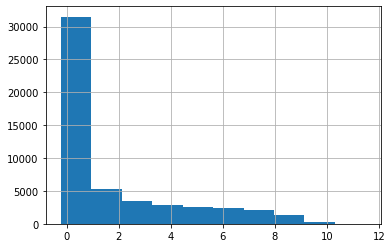

In [31]:
submission1['UV'].hist()      

In [50]:
submission1[submission1['UV']<1]

,YearMonthDayHourMinute,STN,UV
0,202206010000,13,-0.006088
1,202206010000,105,-0.007011
2,202206010000,108,-0.022675
3,202206010000,112,-0.019366
4,202206010000,115,0.004541
...,...,...,...
51850,202206250000,146,0.009567
51851,202206250000,152,0.006638
51852,202206250000,156,-0.008445
51853,202206250000,159,0.008433


In [33]:
submission1[submission1['UV']<7]

,YearMonthDayHourMinute,STN,UV
0,202206010000,13,-0.006088
1,202206010000,105,-0.007011
2,202206010000,108,-0.022675
3,202206010000,112,-0.019366
4,202206010000,115,0.004541
...,...,...,...
51850,202206250000,146,0.009567
51851,202206250000,152,0.006638
51852,202206250000,156,-0.008445
51853,202206250000,159,0.008433


# 아래는 비율 확인한 것

In [52]:
li = list(submission1['UV'].values)
li

li_0_1=[]
li_1_2=[]
li_2_3=[]
li_3_4=[]
li_4_5=[]
li_5_6=[]
li_6_7=[]
li_7_8=[]
li_8_9=[]
li_9_10=[]
li_10_11=[]
li_11_12=[]
li_12_13=[]
li_13_=[]
for i in range(len(li)):
    if (li[i]>=0 and li[i]<1):
        li_0_1.append(li[i])
    elif (li[i]>=1 and li[i]<2):
        li_1_2.append(li[i])
    elif (li[i]>=2 and li[i]<3):
        li_2_3.append(li[i])
    elif (li[i]>=3 and li[i]<4):
        li_3_4.append(li[i])
    elif (li[i]>=4 and li[i]<5):
        li_4_5.append(li[i])
    elif (li[i]>=5 and li[i]<6):
        li_5_6.append(li[i])
    elif (li[i]>=6 and li[i]<7):
        li_6_7.append(li[i])
    elif (li[i]>=7 and li[i]<8):
        li_7_8.append(li[i])
    elif (li[i]>=8 and li[i]<9):
        li_8_9.append(li[i])
    elif (li[i]>=9 and li[i]<10):
        li_9_10.append(li[i])
    elif (li[i]>=10 and li[i]<11):
        li_10_11.append(li[i])
    elif (li[i]>=11 and li[i]<12):
        li_11_12.append(li[i])
    elif (li[i]>=12 and li[i]<13):
        li_12_13.append(li[i])
    elif li[i]>=13:
        li_13_.append(li[i])
        
df11_num = pd.DataFrame([len(li_0_1),len(li_1_2),len(li_2_3),len(li_3_4),len(li_4_5),len(li_5_6),\
                        len(li_6_7),len(li_7_8),len(li_8_9),len(li_9_10),len(li_10_11),len(li_11_12),len(li_12_13),\
                        len(li_13_)])
df11_num

df11_ratio = pd.DataFrame([100*len(li_0_1)/len(li), 100*len(li_1_2)/len(li), 100*len(li_2_3)/len(li),\
                         100*len(li_3_4)/len(li), 100*len(li_4_5)/len(li), 100*len(li_5_6)/len(li), \
                          100*len(li_6_7)/len(li),100*len(li_7_8)/len(li),100*len(li_8_9)/len(li),100*len(li_9_10)/len(li),\
                          100*len(li_10_11)/len(li),100*len(li_11_12)/len(li),100*len(li_12_13)/len(li),\
                          100*len(li_13_)/len(li)])
df11_ratio

df11_1 = pd.concat([df11_num,df11_ratio],axis=1)
df11_1.columns = ['_num','_ratio']
df11_1.index = ['0_1','1_2','2_3','3_4','4_5','5_6','6_7','7_8','8_9','9_10','10_11','11_12','12_13','13_']
df11_1

,_num,_ratio
0_1,19345,37.305949
1_2,4643,8.953814
2_3,3140,6.055347
3_4,2692,5.191399
4_5,2219,4.279240
5_6,2100,4.049754
6_7,1899,3.662135
7_8,1756,3.386366
8_9,1195,2.304503
9_10,388,0.748240


In [54]:
li = list(pd.read_csv('220224_xgb_uv_nooutlier_summer1.csv')['UV'].values)
li_0_1=[]
li_1_2=[]
li_2_3=[]
li_3_4=[]
li_4_5=[]
li_5_6=[]
li_6_7=[]
li_7_8=[]
li_8_9=[]
li_9_10=[]
li_10_11=[]
li_11_12=[]
li_12_13=[]
li_13_=[]
for i in range(len(li)):
    if (li[i]>=0 and li[i]<1):
        li_0_1.append(li[i])
    elif (li[i]>=1 and li[i]<2):
        li_1_2.append(li[i])
    elif (li[i]>=2 and li[i]<3):
        li_2_3.append(li[i])
    elif (li[i]>=3 and li[i]<4):
        li_3_4.append(li[i])
    elif (li[i]>=4 and li[i]<5):
        li_4_5.append(li[i])
    elif (li[i]>=5 and li[i]<6):
        li_5_6.append(li[i])
    elif (li[i]>=6 and li[i]<7):
        li_6_7.append(li[i])
    elif (li[i]>=7 and li[i]<8):
        li_7_8.append(li[i])
    elif (li[i]>=8 and li[i]<9):
        li_8_9.append(li[i])
    elif (li[i]>=9 and li[i]<10):
        li_9_10.append(li[i])
    elif (li[i]>=10 and li[i]<11):
        li_10_11.append(li[i])
    elif (li[i]>=11 and li[i]<12):
        li_11_12.append(li[i])
    elif (li[i]>=12 and li[i]<13):
        li_12_13.append(li[i])
    elif li[i]>=13:
        li_13_.append(li[i])
        
df11_num = pd.DataFrame([len(li_0_1),len(li_1_2),len(li_2_3),len(li_3_4),len(li_4_5),len(li_5_6),\
                        len(li_6_7),len(li_7_8),len(li_8_9),len(li_9_10),len(li_10_11),len(li_11_12),len(li_12_13),\
                        len(li_13_)])
df11_num

df11_ratio = pd.DataFrame([100*len(li_0_1)/len(li), 100*len(li_1_2)/len(li), 100*len(li_2_3)/len(li),\
                         100*len(li_3_4)/len(li), 100*len(li_4_5)/len(li), 100*len(li_5_6)/len(li), \
                          100*len(li_6_7)/len(li),100*len(li_7_8)/len(li),100*len(li_8_9)/len(li),100*len(li_9_10)/len(li),\
                          100*len(li_10_11)/len(li),100*len(li_11_12)/len(li),100*len(li_12_13)/len(li),\
                          100*len(li_13_)/len(li)])
df11_ratio

df11_1 = pd.concat([df11_num,df11_ratio],axis=1)
df11_1.columns = ['_num','_ratio']
df11_1.index = ['0_1','1_2','2_3','3_4','4_5','5_6','6_7','7_8','8_9','9_10','10_11','11_12','12_13','13_']
df11_1

,_num,_ratio
0_1,31162,60.094494
1_2,4164,8.030084
2_3,3614,6.969434
3_4,2792,5.384245
4_5,2430,4.686144
5_6,2264,4.366021
6_7,2009,3.874265
7_8,1704,3.286086
8_9,1325,2.555202
9_10,374,0.721242


In [ ]:
# 관측소별로 자외선 지수 분석할지.

<AxesSubplot:>

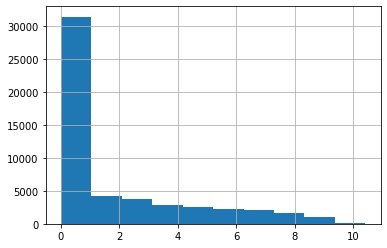

In [46]:
pd.read_csv('220224_xgb_uv_nooutlier_summer1.csv')['UV'].hist()

In [86]:
# pd.read_csv('220224.csv')

,YearMonthDayHourMinute,STN,UV
0,2.022060e+11,13,0.00471
1,2.022060e+11,105,0.00471
2,2.022060e+11,108,0.00471
3,2.022060e+11,112,0.00471
4,2.022060e+11,115,0.00471
...,...,...,...
51850,2.022060e+11,146,0.00471
51851,2.022060e+11,152,0.00471
51852,2.022060e+11,156,0.00471
51853,2.022060e+11,159,0.00471
